# Import MNIST

In [60]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
transform = transforms.Compose([transforms.ToTensor()])   

dataset = 'CIFAR10'

if dataset=='MNIST':
    ds = datasets.MNIST(root='data', transform=transform)
    
elif dataset=='CIFAR10':
    ds = datasets.CIFAR10(root='data', transform=transform)

ds_dim = np.prod(ds[0][0].numpy().shape)
ds_train, ds_test = random_split(ds, [len(ds)-10000, 10000])

dl_train, dl_test = DataLoader(ds_train, batch_size=64), DataLoader(ds_test, batch_size=64)

In [147]:
images, classes = next(iter(dl_test))

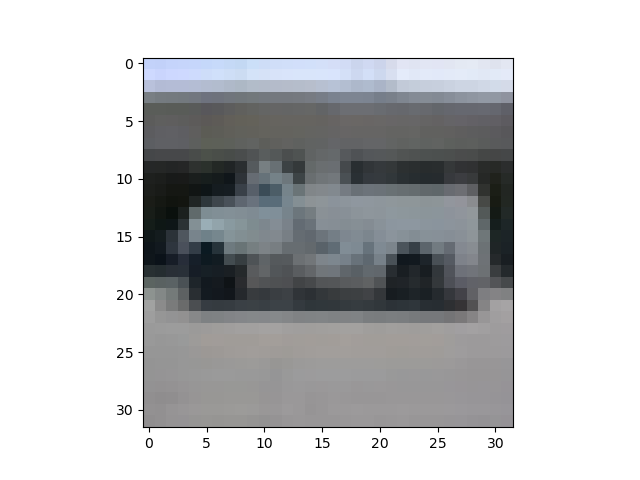

In [148]:
%matplotlib widget
plt.imshow(np.transpose(images[0], (1,2,0)))

# Setup general train/eval pipeline 

In [192]:
import torch.optim as optim

class Pipeline():
    def __init__(self, model, dataloader_train, dataloader_test, n_epochs=50, lr=0.005, is_variational=False):
        self.model = model
        
        self.is_variational = is_variational
        
        self.dl_train = dataloader_train
        self.dl_test = dataloader_test
        self.n_epochs = n_epochs
        
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        

    def train(self):
        self.model.train()
        
        for epoch in range(self.n_epochs):
            running_loss = 0.0
            for i, data in enumerate(self.dl_train, 0):
                imgs, labels = data
                
                out = self.model(imgs)
                loss = self.loss(out, labels)
                
                if self.is_variational:
                    kl = self.model.kl()
                    loss_total = loss + kl/10
                else:
                    loss_total = loss
                    
                self.optimizer.zero_grad()
                loss_total.backward()
                self.optimizer.step()

                running_loss += loss.item()
                if i % 500 == 499:
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
                    running_loss = 0.0
                    
    def evaluate(self):
        correct = i = 0
        
        self.model.eval()
        for images, classes in dl_test:
            for img, c in zip(images, classes):
                pred_score = torch.argmax(nn.Softmax(dim=0)(self.model(img, train=False)))
                correct += pred_score == c
                i += 1

        print('Finished Training')
        print(f'Accuracy is {100*correct/i:.2f}%')

# Setup traditional MLP classifier as baseline

In [193]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        
        self.flatten = nn.Flatten()
        self.layer1 = nn.Sequential(nn.Linear(dim, 512), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.linear_last = nn.Linear(256, 10)

    def forward(self, x, train=True):
        x = self.flatten(x)
        if not train:
            x = nn.Flatten(start_dim=0, end_dim=-1)(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.linear_last(x)
        
        return x

mlp = MLP(dim=ds_dim)
print(mlp)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear_last): Linear(in_features=256, out_features=10, bias=True)
)


In [196]:
pl = Pipeline(model=mlp, dataloader_train=dl_train, dataloader_test=dl_test, n_epochs=10)
pl.train()

[1,   500] loss: 1.820
[2,   500] loss: 1.793
[3,   500] loss: 1.779
[4,   500] loss: 1.766
[5,   500] loss: 1.757
[6,   500] loss: 1.755
[7,   500] loss: 1.748
[8,   500] loss: 1.741
[9,   500] loss: 1.734
[10,   500] loss: 1.730


In [197]:
pl.evaluate()

Finished Training
Accuracy is 36.34%


# Dropout Classifier - Bernoulli

In [203]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLP_dropout_bernoulli(nn.Module):
    def __init__(self, dim, p):
        super(MLP_dropout_bernoulli, self).__init__()
        
        self.flatten = nn.Flatten()
        self.layer1 = nn.Sequential(nn.Linear(dim, 512), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.linear_last = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(p=p)

    def forward(self, x, train=True):
        x = self.flatten(x)
        if not train:
            x = nn.Flatten(start_dim=0, end_dim=-1)(x)
        x = self.layer1(x)
        if train==True:
            x = self.dropout(x)
        x = self.layer2(x)
        if train==True:
            x = self.dropout(x)
        x = self.linear_last(x)
        
        return x

mlp_dropout_bernoulli = MLP_dropout_bernoulli(dim=ds_dim, p=0.1)
print(mlp_dropout_bernoulli)

MLP_dropout_bernoulli(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear_last): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [204]:
pl_bernoulli = Pipeline(model=mlp_dropout_bernoulli, dataloader_train=dl_train, dataloader_test=dl_test, n_epochs=10)

pl_bernoulli.train()

[1,   500] loss: 2.051
[2,   500] loss: 1.928
[3,   500] loss: 1.901
[4,   500] loss: 1.879
[5,   500] loss: 1.864
[6,   500] loss: 1.856
[7,   500] loss: 1.845
[8,   500] loss: 1.847
[9,   500] loss: 1.842
[10,   500] loss: 1.823


In [205]:
pl_bernoulli.evaluate()

Finished Training
Accuracy is 36.76%


# Variational Dropout

In [212]:
import numpy as np
from torch.autograd import Variable

class dropout_variational(nn.Module):
    def __init__(self, alpha=1.0, dim=28):
        super(dropout_variational, self).__init__()
        
        self.dim = dim
        self.max_log_alpha = np.log(alpha)
        self.log_alpha = nn.Parameter(torch.ones(dim)*np.log(alpha))
        
    def kl(self):
        c1 = 1.16145124
        c2 = -1.50204118
        c3 = 0.58629921
        
        
        kl = -1*(0.5 * self.log_alpha + c1 * self.log_alpha.exp() + c2 * self.log_alpha.exp()**2 + c3 * self.log_alpha.exp()**3)
        return kl.mean()
    
    def forward(self, x):
        """
        Sample noise   e ~ N(1, alpha)
        Multiply noise h = h_ * e
        """
        epsilon = Variable(torch.randn(x.size()))
        
        self.log_alpha.data = torch.clamp(self.log_alpha.data, max=self.max_log_alpha)
        alpha = self.log_alpha.exp()

        # N(1, alpha)
        epsilon = epsilon*alpha

        return x * (1+epsilon)
        
class MLP_dropout_variational(nn.Module):
    def __init__(self, dim, alpha=0.25):
        super(MLP_dropout_variational, self).__init__()
        
        self.flatten = nn.Flatten()
        self.layer1 = nn.Sequential(nn.Linear(dim, 512), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.linear_last = nn.Linear(256, 10)
        
        self.dropout0 = dropout_variational(dim=dim, alpha=alpha)
        self.dropout1 = dropout_variational(dim=512, alpha=alpha)
        self.dropout2 = dropout_variational(dim=256, alpha=alpha)

    def kl(self):
        kl = 0
        for name, module in self.named_modules():
            if isinstance(module, dropout_variational):
                kl += module.kl().sum()
        return kl
        
    def forward(self, x, train=True):
        x = self.flatten(x)
        if not train:
            x = nn.Flatten(start_dim=0, end_dim=-1)(x)        
        if train==True:
            x = self.dropout0(x)
        x = self.layer1(x)
        if train==True:
            x = self.dropout1(x)
        x = self.layer2(x)
        if train==True:
            x = self.dropout2(x)
        x = self.linear_last(x)
        
        return x

mlp_dropout_variational = MLP_dropout_variational(dim=ds_dim, alpha=0.25)
print(mlp_dropout_variational)

MLP_dropout_variational(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear_last): Linear(in_features=256, out_features=10, bias=True)
  (dropout0): dropout_variational()
  (dropout1): dropout_variational()
  (dropout2): dropout_variational()
)


In [214]:
pl_variational = Pipeline(model=mlp_dropout_variational, dataloader_train=dl_train, dataloader_test=dl_test, n_epochs=10, is_variational=True)

pl_variational.train()

[1,   500] loss: 1.859
[2,   500] loss: 1.795
[3,   500] loss: 1.763
[4,   500] loss: 1.737
[5,   500] loss: 1.720
[6,   500] loss: 1.705
[7,   500] loss: 1.701
[8,   500] loss: 1.694
[9,   500] loss: 1.687
[10,   500] loss: 1.686


In [215]:
pl_variational.evaluate()

Finished Training
Accuracy is 37.85%


TypeError: Invalid shape (3, 32, 32) for image data

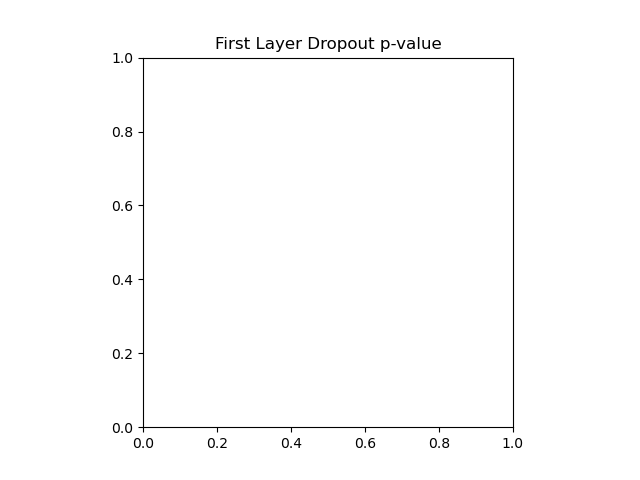

In [222]:
%matplotlib widget
alpha_0 = mlp_dropout_variational.dropout0.log_alpha.exp().view(ds[0][0].shape).detach().numpy()

plt.title("First Layer Dropout p-value")
plt.imshow(alpha_0/(1+alpha_0), cmap='gray')
plt.colorbar()

# plot MNIST distribution 

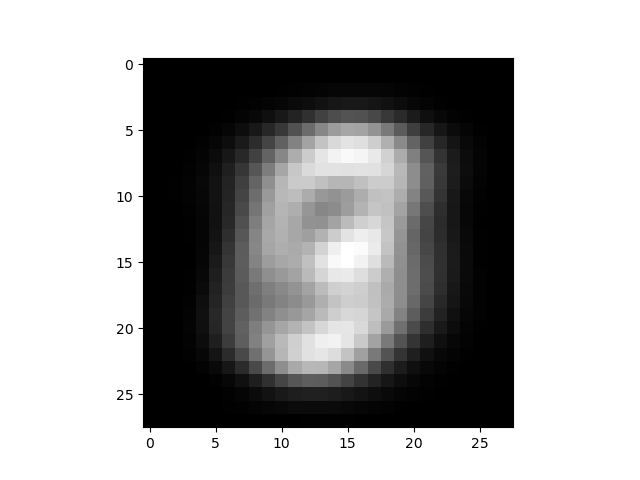

In [100]:
%matplotlib widget

total = 0
for im in ds_train:
    total+=im[0][0]
    
plt.imshow(total, cmap='gray')